In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle
from nltk.corpus import stopwords

%matplotlib inline

no_alignment_file = [4764]
wrong_alignment = [3730]

In [2]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

/Users/roblescoulter/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def generate_word2vec_text8(saveTo = 'models/text8.model'):
    sentences = word2vec.Text8Corpus('data/text8')
    model = word2vec.Word2Vec(sentences, size=EMBEDDING_DIM)
    model.save(saveTo)
    model.wv.save_word2vec_format(saveTo + '.bin', binary=True)
    print('DONE! Saved to', saveTo)

def generate_glove_text8(saveTo = 'models/glovetext8.model'):
    import itertools
    sentences = list(itertools.islice(word2vec.Text8Corpus('data/text8'),None))
    corpus = Corpus()
    corpus.fit(sentences, window=10)
    glove = Glove(no_components=EMBEDDING_DIM,learning_rate=0.05)
    glove.fit(corpus.matrix, epochs=30,no_threads=4,verbose=True)
    glove.add_dictionary(corpus.dictionary)
    glove.save(saveTo)
    print('DONE! Saved to', saveTo)
    
def load_data(word_count, emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences_votebased.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    # Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
#     data,patterns = remove_empty_patterns(data,patterns)
    return data

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(".*?\[(.*?)\]","",text) # Take out any [action] text in the transcript
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    text = ' '.join(tokens)
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]

def balance_data(data):
    min_sample = min(data.groupby('emotion').count()['emotion_code'])
    emotions_list = list(data['emotion'].unique())
    samples = []
    for emotion in emotions_list:
        samples.append(data[data.emotion == emotion].sample(n=min_sample))
    result = pd.concat(samples).sample(frac=1)
    return result


In [39]:
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data = load_data(5, emotional_mapping)
# data = balance_data(data)
df = data[['text','emotion_code']]
df.groupby('emotion_code').count()

,text
emotion_code,
0,711
1,538
2,356
3,847


In [40]:
total = sum(data.groupby('emotion').count()['emotion_code'])
((data.groupby('emotion').count() / total) * 100)['emotion_code']

emotion
ang    28.996737
hap    14.518760
neu    34.543230
sad    21.941272
Name: emotion_code, dtype: float64

In [28]:
# data_balanced = balance_data(data)
# df_balanced = data_balanced[['text','emotion_code']]
# df_balanced.head()
# data_balanced.groupby('emotion').count()

## Parameter

In [41]:
# DATASET
TEST_SIZE      = 0.1

# EMBEDDING
MAX_NUM_WORDS  = 1800 
EMBEDDING_DIM  = 200
MAX_SEQ_LENGTH = 100
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [2,2,3]
FEATURE_MAPS   = [100,100,100]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 50
RUNS           = 5
VAL_SIZE       = 0.2

## Preprocessing

In [42]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)

In [43]:

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

word_index = tokenizer.word_index

result = [len(x.split()) for x in x_train]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))

print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 53 / min length: 5 / mean length: 9 / limit length: 100
vocabulary size: 2172 / limit: 1800


# Embeddings

In [44]:
def create_glove_embeddings(data = None, use_text8 = False, LEARNING_RATE=0.05, EPOCHS=30, NO_THREADS=4):
    model = None
    if(use_text8):
        model = Glove.load('models/glovetext8.model')
    else:
        if(data != None):
            corpus = Corpus()
            corpus.fit(data, window=10)
            model = Glove(no_components=EMBEDDING_DIM,learning_rate=LEARNING_RATE)
            model.fit(corpus.matrix, epochs=EPOCHS,no_threads=NO_THREADS,verbose=True)
            model.add_dictionary(corpus.dictionary)
        else:
            print('No data found. Using text8 Corpus')
            model = Glove.load('models/glovetext8.model')
    
    embeddings_index = {}
    for word,index in model.dictionary.items():
        embeddings_index[word] = model.word_vectors[index]
    
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length= MAX_SEQ_LENGTH,
                     weights=[embedding_matrix], trainable=True)
    
def create_word2vec_embeddings(data = None, use_text8 = False):
    model = None
    if(use_text8):
        model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    else:
        if(data != None):  
            model = word2vec.Word2Vec(data, size=EMBEDDING_DIM)
        else:
            print('No data found. Using text8 Corpus')
            model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    
    embeddings_index = {}
    for word in model.wv.index2word:
        embeddings_index[word] = model[word]
        
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length = MAX_SEQ_LENGTH,
                    weights= [embedding_matrix], trainable=True)

# Model Definition

## Training

In [47]:
embedding_data = [x.split() for x in x_train]
emb_layers = [create_word2vec_embeddings(use_text8=True),
              create_word2vec_embeddings(embedding_data),
              create_glove_embeddings(use_text8=True),
              create_glove_embeddings(embedding_data)
             ]

emb_layers_names = ['word2vectext8','word2veciemocap','glovetext8','gloveiemocap']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [48]:
print(len(data),len(y_train))

(1961, 1961)


In [ ]:
import cnn_model

histories = []

import time
for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    start_time = time.time()
    X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

    emb_layer = None
    if USE_GLOVE:
        emb_layer = emb_layers[2]

    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3,lr=0.001),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, labels,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration', i+1)
    print("--- %s seconds on ---" % (time.time() - start_time))
    
# with open('history/'+emb_layers_names[2]+'_'+str(MAX_NUM_WORDS)+'.pkl', 'wb') as f:
#     pickle.dump(histories, f)

Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 1800
Embedding dim: 200
Filter sizes: [2, 2, 3]
Feature maps: [100, 100, 100]
Max sequence: 100
#############################################
Train on 1764 samples, validate on 197 samples
Epoch 1/50
1764/1764 [==============================] - 6s 3ms/step - loss: 12.7763 - acc: 0.2676 - val_loss: 12.7398 - val_acc: 0.2893

Epoch 00001: val_loss improved from inf to 12.73983, saving model to model-1.h5
Epoch 2/50
1764/1764 [==============================] - 5s 3ms/step - loss: 12.7686 - acc: 0.2602 - val_loss: 12.7313 - val_acc: 0.2893

Epoch 00002: val_loss improved from 12.73983 to 12.73133, saving model to model-1.h5
Epoch 3/50
1764/1764 [==============================] - 5s 3ms/step - loss: 12.7645 - acc: 0.2664 - val_loss: 12.7227 - val_acc: 0.2944

Epoch 00003: val_loss improved from 12.73133 to 12.72273, saving model to model-1.h5
Epoc

1764/1764 [==============================] - 3s 2ms/step - loss: 12.4266 - acc: 0.2387 - val_loss: 12.5210 - val_acc: 0.1929

Epoch 00021: val_loss improved from 12.53020 to 12.52096, saving model to model-2.h5
Epoch 22/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.4051 - acc: 0.2347 - val_loss: 12.5117 - val_acc: 0.1929

Epoch 00022: val_loss improved from 12.52096 to 12.51166, saving model to model-2.h5
Epoch 23/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.3935 - acc: 0.2336 - val_loss: 12.5023 - val_acc: 0.1878

Epoch 00023: val_loss improved from 12.51166 to 12.50227, saving model to model-2.h5
Epoch 24/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.3889 - acc: 0.2285 - val_loss: 12.4928 - val_acc: 0.1878

Epoch 00024: val_loss improved from 12.50227 to 12.49284, saving model to model-2.h5
Epoch 25/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.3749 - acc: 0.2353 - val_loss: 12.4834 -

1764/1764 [==============================] - 3s 2ms/step - loss: 12.1918 - acc: 0.2279 - val_loss: 12.3065 - val_acc: 0.1929

Epoch 00043: val_loss improved from 12.31749 to 12.30650, saving model to model-3.h5
Epoch 44/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.1866 - acc: 0.2302 - val_loss: 12.2954 - val_acc: 0.1929

Epoch 00044: val_loss improved from 12.30650 to 12.29541, saving model to model-3.h5
Epoch 45/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.1599 - acc: 0.2273 - val_loss: 12.2842 - val_acc: 0.1929

Epoch 00045: val_loss improved from 12.29541 to 12.28422, saving model to model-3.h5
Epoch 46/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.1495 - acc: 0.2307 - val_loss: 12.2729 - val_acc: 0.1929

Epoch 00046: val_loss improved from 12.28422 to 12.27292, saving model to model-3.h5
Epoch 47/50
1764/1764 [==============================] - 3s 2ms/step - loss: 12.1351 - acc: 0.2290 - val_loss: 12.2616 -

In [109]:
# with open('history/unnamed.pkl', 'wb') as f:
#     pickle.dump(histories, f)

# For Multiple Models

In [35]:
# import cnn_model
# # BALANCED DATA
# printing = {}
# FILTER_SIZES_AR   = [[2,3],[3,5],[2,2],[3,3],[5,5]]
# filter_sizes_names = ['2_3','3_5','2_2','3_3','5_5']
# FEATURE_MAPS_AR   = [[10,10],[50,50],[100,100]] #50,100
# feature_maps_names = ['10','50','100']
# emb_layers_names = ['word2vectext8','glovetext8']
# for Findex,filterS in enumerate(FILTER_SIZES_AR):
#     for Mindex, featureM in enumerate(FEATURE_MAPS_AR):
#         FILTER_SIZES = filterS
#         FEATURE_MAPS = featureM
#         print(FILTER_SIZES)
#         print(FEATURE_MAPS)
#         emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
#         data = load_data(filtering_count, emotional_mapping)
#         df = data[['text','emotion_code']]
#         df.head()
#         x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)
#         tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
#         tokenizer.fit_on_texts(x_train)
#         sequences = tokenizer.texts_to_sequences(x_train)

#         length = max_length(x_train)
#         word_index = tokenizer.word_index

#         result = [len(x.split()) for x in x_train]
#         data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

#         embedding_data = [x.split() for x in x_train]
#         emb_layers = [create_word2vec_embeddings(use_text8=True),
#     #                   create_word2vec_embeddings(embedding_data),
#                       create_glove_embeddings(use_text8=True),
#     #                   create_glove_embeddings(embedding_data)
#                      ]

#     #     ######################################################
#         for index,lay in enumerate(emb_layers):

#             histories = []

#             for i in range(RUNS):
#                 print('Running iteration %i/%i' % (i+1, RUNS))

#                 X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

#                 emb_layer = None
#                 if USE_GLOVE:
#                     emb_layer = lay#emb_layers[2] #create_word2vec_embeddings(result)

#                 model = cnn_model.build_cnn(
#                     embedding_layer=emb_layer,
#                     num_words=MAX_NUM_WORDS,
#                     embedding_dim=EMBEDDING_DIM,
#                     filter_sizes=FILTER_SIZES,
#                     feature_maps=FEATURE_MAPS,
#                     max_seq_length=MAX_SEQ_LENGTH,
#                     dropout_rate=DROPOUT_RATE
#                 )

#                 model.compile(
#                     loss='binary_crossentropy',
#                     optimizer=Adadelta(clipvalue=3),
#                     metrics=['accuracy']
#                 )

#                 history = model.fit(
#                     X_train, labels,
#                     epochs=NB_EPOCHS,
#                     batch_size=BATCH_SIZE,
#                     verbose=1,
#                     validation_data=(X_val, y_val),
#                     callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
#                                                verbose=1, save_best_only=True, mode='min'),
#                                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#                               ]
#                 )
#                 histories.append(history.history)

#             with open('history/V3/'+emb_layers_names[index]+'_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'.pkl', 'wb') as f:
#                 pickle.dump(histories, f)
#             printing['history/V3/'+emb_layers_names[index]+'_FS'+str(filter_sizes_names[Findex])+'_FM_'+str(feature_maps_names[Mindex])+'.pkl'] = [get_avg(histories, 'loss'),get_avg(histories, 'acc'),get_avg(histories, 'val_loss'),get_avg(histories, 'val_acc')]



228/228 [==============================] - 0s 217us/step


(array([26., 55., 49., 43., 21., 15.,  9.,  7.,  2.,  1.]),
 array([0.49802047, 0.51203679, 0.52605312, 0.54006944, 0.55408577,
        0.56810209, 0.58211842, 0.59613474, 0.61015106, 0.62416739,
        0.63818371]),
 <a list of 10 Patch objects>)

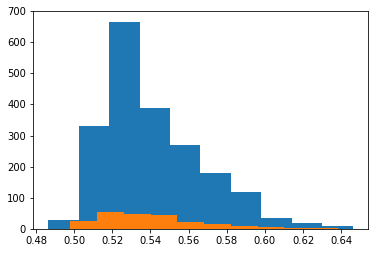

In [142]:
train_predictions = model.predict(X_train, verbose=1)
plt.hist(train_predictions)
test_predictions = model.predict(X_val,verbose=1)
plt.hist(test_predictions)

# Evaluation 

In [ ]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

def get_scores_from_multiple(history_folder):
    V_folder = os.listdir(history_folder)
    values = []
    for pkl in V_folder:
        history = pickle.load(open(history_folder+pkl, 'rb'))
        values.append([pkl,get_avg(history,'acc'),get_avg(history,'val_acc'),get_avg(history,'loss'),get_avg(history,'val_loss')])
    # histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))
    scores = pd.DataFrame(data=values,columns=['Model','Train Acc','Valid Acc','Train Loss','Valid Loss'])
    return scores


In [15]:
# V3_scores = get_scores_from_multiple('history/V3/')
# V3_3Maps_scores = get_scores_from_multiple('history/V3_size3Maps/')

In [65]:
# V3_3Maps_scores.sort_values(by='Valid Acc',ascending=False)

In [ ]:
# histories = pickle.load(open('history/V3_size3Maps/glovetext8_FS223_FM_100.pkl', 'rb'))
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

In [69]:
def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

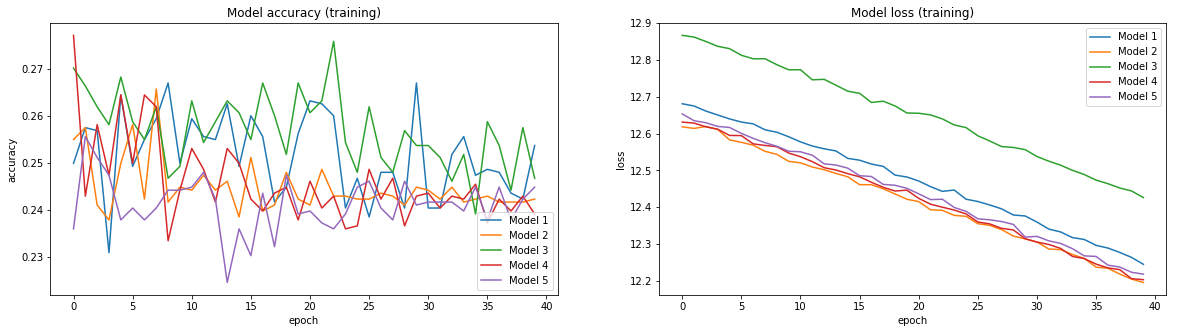

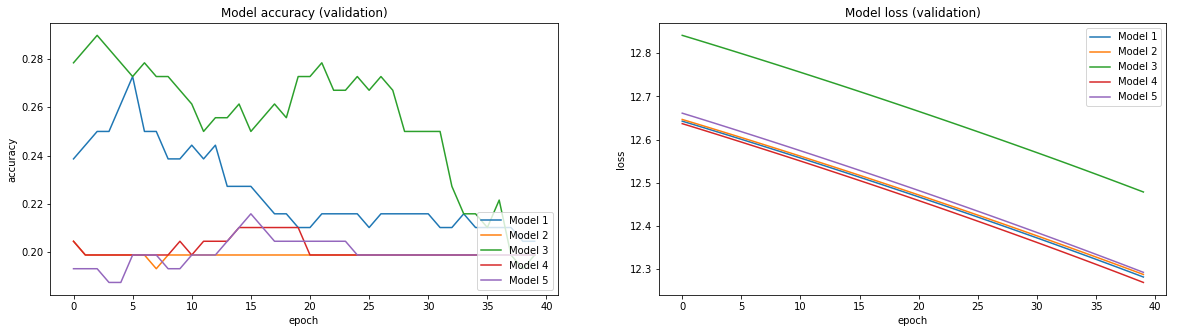

In [70]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')